In [288]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
from src.tree import * 
import matplotlib.cm 
import matplotlib.colors
from scipy.stats import chisquare
import src.tools as tools
from src.coevolution import *



In [291]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

In [300]:
def annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')


index, alignment = load_msa(path='../data/arf1_cleaned.afa', ids=arf1_df.index) # Should load the sequences from Methanosarcinales only. 
alignment_df = pd.DataFrame(alignment, index=index)

seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)

get_domain_boundaries: NIKS boundaries 54-58.
get_domain_boundaries: YxCxxxF boundaries 118-125.
get_domain_boundaries: GTS boundaries 22-25.


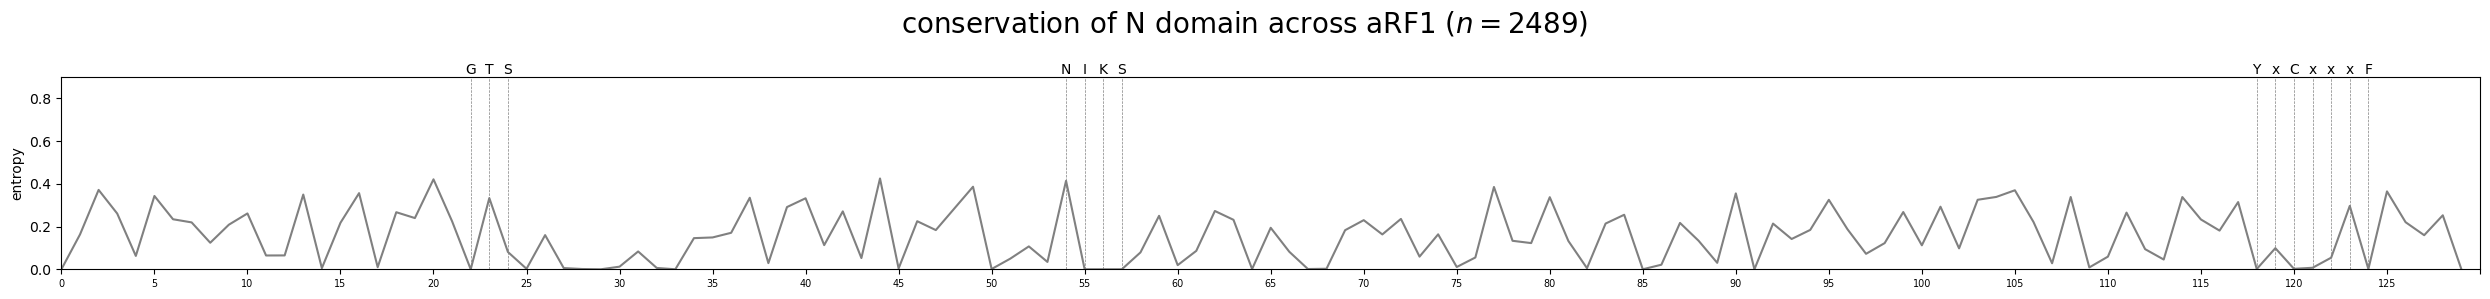

In [313]:
# Want a simple figure showing conservation at the N-terminus. 

fig, ax = plt.subplots(figsize=(25, 3))

index, alignment = load_msa(path='../data/arf1_cleaned.afa', ids=arf1_df.index) # Should load the sequences from Methanosarcinales only. 
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df = alignment_df.replace(dayhoff)


entropies = get_entropies(alignment_df)[0]
plot_scores_1d(entropies, ax=ax, color='gray', start=0, stop=130)

ax.set_xticks(np.arange(0, 150, 5))
ax.set_ylabel('entropy')
fig.suptitle(f'conservation of N domain across aRF1 ($n={len(arf1_df)}$)', fontsize=20)
# ax.set_title(f'conservation of N domain across aRF1 ($n={len(arf1_df)}$)')

ax.set_ylim(ymin=0, ymax=0.9)
ax.set_xlim(xmin=0, xmax=130)

annotate_residues(domain_boundaries, ax=ax)

fig.tight_layout()
plt.show()
# print(entropies)